<a href="https://colab.research.google.com/github/lauranenart/ObjectLocalizationClassification/blob/main/model_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.2

  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install matplotlib==3.0.2

  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import numpy as np

d2l.use_svg_display()

In [ ]:
pip install oidv6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!oidv6 downloader en --dataset drive/MyDrive/data --multi-classes --type_csv all --classes "human_body" horse knife --limit 1000

In [5]:
import csv
import pandas as pd
import glob

In [ ]:
header = ['img_path', 'class', 'x0', 'y0', 'x1', 'x2']

for type in ['test', 'train', 'validation']:
  f = open('/content/drive/My Drive/filtered_data/' + type + '.csv', 'w')
  writer = csv.writer(f)
  writer.writerow(header)

  for folder in ['horse', 'human_body', 'knife']:
    for img_path in glob.glob('/content/drive/My Drive/data/' + type + '/' + folder + '/*.jpg'):
      img = img_path.rsplit("/", 1)[1]
      data = []
      data.append(img)
      with open(img_path.rsplit("/", 1)[0] + '/labels/' + img.rsplit(".", 1)[0] + '.txt','r') as f:
        for line in f:
          columns = line.split()
      data = data + columns
      writer.writerow(data)

  f.close()

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/filtered_data/train.csv")
valid_df = pd.read_csv("/content/drive/My Drive/filtered_data/validation.csv")
test_df = pd.read_csv("/content/drive/My Drive/filtered_data/test.csv")

In [ ]:
train_df.head()

,img_path,class,x0,y0,x1,x2
0,0003d1891fd14575.jpg,horse,323.840000,211.877528,764.800000,518.491254
1,00061d30b2965c3e.jpg,horse,373.760256,108.800000,494.079744,396.800000
2,0006476c7a10ac38.jpg,horse,314.880000,147.840000,755.840256,845.440000
3,000851174d48d3d9.jpg,horse,145.280000,9.610493,893.440000,682.359346
4,000a12b69b0de9f2.jpg,horse,160.640000,67.839744,933.760000,714.879744


In [ ]:
train_df.shape

(2509, 6)

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [7]:
labels_to_num= {'horse':0, 'human_body': 1, 'knife': 2}

In [8]:
import cv2
import random
import os

In [10]:
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [11]:
def preprocess_dataset(filename, data_type):
  labels = []
  boxes = []
  img_list = []
  height = []
  width = []

  h = 224
  w = 224

  with open(filename) as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(labels_to_num[row[1]])
        
        img_path = row[0]
        image_dir = '/content/drive/My Drive/data/' + data_type + '/' + row[1] 
        
        img_shape  = cv2.imread(os.path.join(image_dir, img_path)).shape
        img  = cv2.imread(os.path.join(image_dir, img_path))
        image = cv2.resize(img, (w, h))

        width_size = (img_shape)[0]/w
        height_size = (img_shape)[1]/h

        height.append(height_size)
        width.append(width_size)

        arr = [float(row[2])/height_size,  
               float(row[3])/width_size,
               float(row[4])/height_size,
               float(row[5])/width_size]
        boxes.append(arr)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if(data_type == "train"):
          img = brightness(img, 0.5, 2.5)

        image = image.astype("float") / 255.0

        img_list.append(image)

  return labels, boxes, np.array(img_list), height, width

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
transform_train = transforms.Compose([
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
transform_valid = transforms.Compose([
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, dataset_type, transform=None, target_transform=None):
        labels, boxes, images, height, width = preprocess_dataset(img_dir + dataset_type +".csv", dataset_type)
        self.labels = labels
        self.images = torch.permute(torch.from_numpy(images),(0,3,1,2)).float()
        self.boxes = torch.from_numpy(np.array(boxes)).float()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]

        label = self.labels[idx]
        boxes = self.boxes[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, boxes

In [16]:
train_dataset = CustomImageDataset("/content/drive/My Drive/filtered_data/", "train", transform=transform_train)
valid_dataset = CustomImageDataset("/content/drive/My Drive/filtered_data/", "validation", transform=transform_valid)

In [17]:
len(train_dataset)

2509

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 64, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
pretrained_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
      for param in model.parameters():
            param.requires_grad = True

In [43]:
feature_extract = True

set_parameter_requires_grad(pretrained_model, feature_extract)

In [44]:
new_classifier = torch.nn.Sequential(*list(pretrained_model.children())[:-1])
new_classifier

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [45]:
import torch.nn.functional as F

In [46]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model_resnet = new_classifier

        self.classification = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 3)
        )

        self.regression = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 4)
		    )

    def forward(self, x):
        x = self.model_resnet(x)
        x = x.view(x.size(0), -1)

        out1 = self.classification(x)
        out2 = self.regression(x)

        return out1, out2

In [47]:
model = CustomModel()
model = model.to(device)
model

CustomModel(
  (model_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [48]:
import torch.optim as optim

In [49]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classification.0.weight
	 classification.0.bias
	 classification.2.weight
	 classification.2.bias
	 classification.4.weight
	 classification.4.bias
	 classification.7.weight
	 classification.7.bias
	 regression.0.weight
	 regression.0.bias
	 regression.2.weight
	 regression.2.bias
	 regression.4.weight
	 regression.4.bias
	 regression.6.weight
	 regression.6.bias


In [50]:
optimizer = optim.Adam(params_to_update, lr=0.001)
criterion_classes = nn.CrossEntropyLoss()
criterion_boxes = nn.MSELoss()

In [51]:
H = {
	"train_loss_classes": [],
	"train_acc_classes": [],
	"val_loss_classes": [],
	"val_acc_classes": [],
  "train_loss_boxes": [],
	"train_acc_boxes": [],
	"val_loss_boxes": [],
	"val_acc_boxes": []
}

trainSteps = len(train_loader.dataset) // 64
valSteps = len(valid_loader.dataset) // 64

In [52]:
def CalculateIoU(pred_boxes, boxes):
  
  iou_threshold = 0.5

  results = []

  for (pred_box, box) in zip(pred_boxes.cpu(), boxes.cpu()):
    
    x0_pred, y0_pred, x1_pred, y1_pred = pred_box
    x0, y0, x1, y1 = box

    if(x0 > x1) or (y0 > y1):
      raise AssertionError("Ground Truth Bounding Box is not correct")
    if(x0_pred > x1_pred) or (y0_pred > y1_pred):
      results.append(0.0 >= 0.5)

    if(x1 < x0_pred):
      results.append(0.0 >= 0.5)
    if(y1 < y0_pred):
      results.append(0.0 >= 0.5)
    if(x0 > x1_pred):
      results.append(0.0 >= 0.5)
    if(y0 > y1_pred):
      results.append(0.0 >= 0.5)
    else:
      bbox_area = (x1 - x0 + 1) * (y1 - y0 + 1)
      bbox_area_pred = (x1_pred - x0_pred + 1) * (y1_pred - y0_pred + 1)

      x_top_left = np.max([x0.detach().numpy(), x0_pred.detach().numpy()])
      y_top_left = np.max([y0.detach().numpy(), y0_pred.detach().numpy()])
      x_bottom_right = np.max([x1.detach().numpy(), x1_pred.detach().numpy()])
      y_bottom_right = np.max([y1.detach().numpy(), y1_pred.detach().numpy()])

      intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left + 1)
      
      union_area = (bbox_area + bbox_area_pred - intersection_area)
      result = (intersection_area/union_area) >= iou_threshold
      results.append(result.item())

  return torch.tensor(results)

Feature Extraction

In [53]:
epochs = 20

for e in range(0, epochs):
  model.train()

  totalTrainLossClasses = 0
  totalValLossClasses = 0
  trainCorrectClasses = 0
  valCorrectClasses = 0

  total_train = 0
  total_valid = 0

  totalTrainLossBoxes = 0
  totalValLossBoxes = 0
  trainCorrectBoxes = 0
  valCorrectBoxes = 0
  
  for batch_idx, (images, labels, boxes) in enumerate(train_loader, 0):
    (images, labels, boxes) = (images.to(device, non_blocking=True), labels.to(device, non_blocking=True), boxes.to(device, non_blocking=True))
    
    pred_labels, pred_boxes = model(images)
    loss_classes = criterion_classes(pred_labels, labels)
    loss_boxes = criterion_boxes(pred_boxes, boxes)

    optimizer.zero_grad()
    (loss_classes + loss_boxes).backward()
    optimizer.step()

    totalTrainLossClasses += loss_classes
    trainCorrectClasses += (pred_labels.argmax(1) == labels).type(torch.float).sum().item()

    totalTrainLossBoxes += loss_boxes.item()
    trainCorrectBoxes += (CalculateIoU(pred_boxes, boxes)).type(torch.float).sum().item()

    torch.cuda.empty_cache()
    
  with torch.no_grad():
    model.eval()

    for batch_idx, (images, labels, boxes) in enumerate(valid_loader, 0):
      (images, labels, boxes) = (images.to(device, non_blocking=True), labels.to(device, non_blocking=True), boxes.to(device, non_blocking=True))

      pred_labels, pred_boxes = model(images)
      totalValLossClasses += criterion_classes(pred_labels, labels)
      totalValLossBoxes += criterion_boxes(pred_boxes, boxes)

      valCorrectClasses += (pred_labels.argmax(1) == labels).type(torch.float).sum().item()
      valCorrectBoxes += (CalculateIoU(pred_boxes, boxes)).type(torch.float).sum().item()

      torch.cuda.empty_cache()
    
  avgTrainLossClasses = totalTrainLossClasses / trainSteps
  avgValLossClasses = totalValLossClasses / valSteps
  trainCorrectClasses = trainCorrectClasses / len(train_loader.dataset)
  valCorrectClasses = valCorrectClasses / len(valid_loader.dataset)

  avgTrainLossBoxes = totalTrainLossBoxes / trainSteps
  avgValLossBoxes = totalValLossBoxes / valSteps
  trainCorrectBoxes = trainCorrectBoxes / len(train_loader.dataset)
  valCorrectBoxes = valCorrectBoxes / len(valid_loader.dataset)

  
  H["train_loss_classes"].append(avgTrainLossClasses.cpu().detach().numpy())
  H["train_acc_classes"].append(trainCorrectClasses)
  H["val_loss_classes"].append(avgValLossClasses.cpu().detach().numpy())
  H["val_acc_classes"].append(valCorrectClasses)

  H["train_loss_boxes"].append(avgTrainLossBoxes)
  H["train_acc_boxes"].append(trainCorrectBoxes)
  H["val_loss_boxes"].append(avgValLossBoxes.cpu().detach().numpy())
  H["val_acc_boxes"].append(valCorrectBoxes)

  print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
  print("Train loss classes: {:.6f}, Train accuracy classes: {:.4f}, Train loss boxes: {:.6f}, Train accuracy boxes: {:.4f}".format(
    avgTrainLossClasses, trainCorrectClasses, avgTrainLossBoxes, trainCorrectBoxes))
  print("Val loss classes: {:.6f}, Val accuracy classes: {:.4f}, Val loss boxes: {:.6f}, Val accuracy boxes: {:.4f}\n".format(
    avgValLossClasses, valCorrectClasses, avgValLossBoxes, valCorrectBoxes))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[INFO] EPOCH: 1/20
Train loss classes: 0.389167, Train accuracy classes: 0.8430, Train loss boxes: 6080.293282, Train accuracy boxes: 0.6708
Val loss classes: 0.269803, Val accuracy classes: 0.9026, Val loss boxes: 2848.907715, Val accuracy boxes: 0.8256

[INFO] EPOCH: 2/20
Train loss classes: 0.247725, Train accuracy classes: 0.9195, Train loss boxes: 2617.242957, Train accuracy boxes: 0.7856
Val loss classes: 0.261898, Val accuracy classes: 0.9269, Val loss boxes: 2624.569824, Val accuracy boxes: 0.8526

[INFO] EPOCH: 3/20
Train loss classes: 0.179848, Train accuracy classes: 0.9398, Train loss boxes: 2519.713520, Train accuracy boxes: 0.7788
Val loss classes: 0.294656, Val accuracy classes: 0.8782, Val loss boxes: 2923.187012, Val accuracy boxes: 0.7667

[INFO] EPOCH: 4/20
Train loss classes: 0.146584, Train accuracy classes: 0.9482, Train loss boxes: 2463.414285, Train accuracy boxes: 0.7772
Val loss classes: 0.145675, Val accuracy classes: 0.9513, Val loss boxes: 2582.382324, Val 

Fine-Tuning

In [54]:
feature_extract = False

set_parameter_requires_grad(model, feature_extract)

In [55]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 model_resnet.0.weight
	 model_resnet.1.weight
	 model_resnet.1.bias
	 model_resnet.4.0.conv1.weight
	 model_resnet.4.0.bn1.weight
	 model_resnet.4.0.bn1.bias
	 model_resnet.4.0.conv2.weight
	 model_resnet.4.0.bn2.weight
	 model_resnet.4.0.bn2.bias
	 model_resnet.4.0.conv3.weight
	 model_resnet.4.0.bn3.weight
	 model_resnet.4.0.bn3.bias
	 model_resnet.4.0.downsample.0.weight
	 model_resnet.4.0.downsample.1.weight
	 model_resnet.4.0.downsample.1.bias
	 model_resnet.4.1.conv1.weight
	 model_resnet.4.1.bn1.weight
	 model_resnet.4.1.bn1.bias
	 model_resnet.4.1.conv2.weight
	 model_resnet.4.1.bn2.weight
	 model_resnet.4.1.bn2.bias
	 model_resnet.4.1.conv3.weight
	 model_resnet.4.1.bn3.weight
	 model_resnet.4.1.bn3.bias
	 model_resnet.4.2.conv1.weight
	 model_resnet.4.2.bn1.weight
	 model_resnet.4.2.bn1.bias
	 model_resnet.4.2.conv2.weight
	 model_resnet.4.2.bn2.weight
	 model_resnet.4.2.bn2.bias
	 model_resnet.4.2.conv3.weight
	 model_resnet.4.2.bn3.weight
	 model_resnet.4

In [56]:
optimizer = optim.Adam(params_to_update, lr=0.000015)
criterion_classes = nn.CrossEntropyLoss()
criterion_boxes = nn.MSELoss()

In [57]:
def calculate_iou(box1, box2):
  intersection = np.logical_and(box1.cpu()[0].tolist(), box2.cpu()[0].tolist())
  union = np.logical_or(box1.cpu()[0].tolist(), box2.cpu()[0].tolist())
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [58]:
def get_miou(iou_list):
  return np.mean(iou_list)

In [59]:
epochs = 10

for e in range(0, epochs):
  model.train()

  totalTrainLossClasses = 0
  totalValLossClasses = 0
  trainCorrectClasses = 0
  valCorrectClasses = 0

  total_train = 0
  total_valid = 0

  totalTrainLossBoxes = 0
  totalValLossBoxes = 0
  trainCorrectBoxes = 0
  valCorrectBoxes = 0

  iou_list = []
  
  for batch_idx, (images, labels, boxes) in enumerate(train_loader, 0):
    (images, labels, boxes) = (images.to(device, non_blocking=True), labels.to(device, non_blocking=True), boxes.to(device, non_blocking=True))
    
    pred_labels, pred_boxes = model(images)
    loss_classes = criterion_classes(pred_labels, labels)
    loss_boxes = criterion_boxes(pred_boxes, boxes)

    optimizer.zero_grad()
    (loss_classes + loss_boxes).backward()
    optimizer.step()

    totalTrainLossClasses += loss_classes
    trainCorrectClasses += (pred_labels.argmax(1) == labels).type(torch.float).sum().item()

    totalTrainLossBoxes += loss_boxes.item()
    trainCorrectBoxes += (CalculateIoU(pred_boxes, boxes)).type(torch.float).sum().item()

    torch.cuda.empty_cache()

  with torch.no_grad():
    model.eval()

    for batch_idx, (images, labels, boxes) in enumerate(valid_loader, 0):
      (images, labels, boxes) = (images.to(device, non_blocking=True), labels.to(device, non_blocking=True), boxes.to(device, non_blocking=True))

      pred_labels, pred_boxes = model(images)
      totalValLossClasses += criterion_classes(pred_labels, labels)
      totalValLossBoxes += criterion_boxes(pred_boxes, boxes)

      valCorrectClasses += (pred_labels.argmax(1) == labels).type(torch.float).sum().item()
      valCorrectBoxes += (CalculateIoU(pred_boxes, boxes)).type(torch.float).sum().item()

      iou_list.append(calculate_iou(pred_boxes, boxes))

      torch.cuda.empty_cache()
    
  avgTrainLossClasses = totalTrainLossClasses / trainSteps
  avgValLossClasses = totalValLossClasses / valSteps
  trainCorrectClasses = trainCorrectClasses / len(train_loader.dataset)
  valCorrectClasses = valCorrectClasses / len(valid_loader.dataset)

  avgTrainLossBoxes = totalTrainLossBoxes / trainSteps
  avgValLossBoxes = totalValLossBoxes / valSteps
  trainCorrectBoxes = trainCorrectBoxes / len(train_loader.dataset)
  valCorrectBoxes = valCorrectBoxes / len(valid_loader.dataset)

  
  H["train_loss_classes"].append(avgTrainLossClasses.cpu().detach().numpy())
  H["train_acc_classes"].append(trainCorrectClasses)
  H["val_loss_classes"].append(avgValLossClasses.cpu().detach().numpy())
  H["val_acc_classes"].append(valCorrectClasses)

  H["train_loss_boxes"].append(avgTrainLossBoxes)
  H["train_acc_boxes"].append(trainCorrectBoxes)
  H["val_loss_boxes"].append(avgValLossBoxes.cpu().detach().numpy())
  H["val_acc_boxes"].append(valCorrectBoxes)

  print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
  print("Train loss classes: {:.6f}, Train accuracy classes: {:.4f}, Train loss boxes: {:.6f}, Train accuracy boxes: {:.4f}".format(
    avgTrainLossClasses, trainCorrectClasses, avgTrainLossBoxes, trainCorrectBoxes))
  print("Val loss classes: {:.6f}, Val accuracy classes: {:.4f}, Val loss boxes: {:.6f}, Val accuracy boxes: {:.4f}\n".format(
  avgValLossClasses, valCorrectClasses, avgValLossBoxes, valCorrectBoxes))
  print("IoU is {:.4f}".format(get_miou(iou_list)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[INFO] EPOCH: 1/10
Train loss classes: 0.055585, Train accuracy classes: 0.9825, Train loss boxes: 1619.801057, Train accuracy boxes: 0.8481
Val loss classes: 0.273257, Val accuracy classes: 0.9205, Val loss boxes: 2113.574219, Val accuracy boxes: 0.8397

IoU is 0.9231
[INFO] EPOCH: 2/10
Train loss classes: 0.044440, Train accuracy classes: 0.9853, Train loss boxes: 1260.269088, Train accuracy boxes: 0.8657
Val loss classes: 0.393952, Val accuracy classes: 0.9218, Val loss boxes: 2163.027832, Val accuracy boxes: 0.8282

IoU is 0.8654
[INFO] EPOCH: 3/10
Train loss classes: 0.052495, Train accuracy classes: 0.9845, Train loss boxes: 1084.540116, Train accuracy boxes: 0.8892
Val loss classes: 0.265329, Val accuracy classes: 0.9282, Val loss boxes: 2163.121338, Val accuracy boxes: 0.8256

IoU is 0.9038
[INFO] EPOCH: 4/10
Train loss classes: 0.039170, Train accuracy classes: 0.9861, Train loss boxes: 948.473567, Train accuracy boxes: 0.9024
Val loss classes: 0.352758, Val accuracy classes: 

In [60]:
torch.save(model, 'model.pt')

In [61]:
model = torch.load('model.pt')
model.eval()

CustomModel(
  (model_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [62]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb, boxes = model(xb)
    _, preds  = torch.max(yb, dim=1)
    print(preds[0])
    print(boxes[0].tolist())
    return preds[0].item(), boxes[0].tolist()

In [63]:
labels_map = {
    0: "horse",
    1: "human_body",
    2: "knife"
}

In [64]:
transform_test = transforms.Compose([
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])

test_dataset = CustomImageDataset("/content/drive/My Drive/filtered_data/", "test", transform=transform_test)

In [65]:
def show_results(idx):
  img, label, boxes = test_dataset[idx]
  print(boxes)
  fig = plt.imshow(img[0])
  fig.axes.add_patch(d2l.plt.Rectangle(xy=(boxes[0], boxes[1]), width=boxes[2]-boxes[0], height=boxes[3]-boxes[1],
          fill=False, edgecolor='blue', linewidth=2))

  pred_label, pred_boxes = predict_image(img, model)
  fig.axes.add_patch(d2l.plt.Rectangle(xy=(pred_boxes[0], pred_boxes[1]), width=pred_boxes[2]-pred_boxes[0], height=pred_boxes[3]-pred_boxes[1],
          fill=False, edgecolor='red', linewidth=2))

  print("Label is: " + labels_map[label], ', Predicted:', labels_map[pred_label])

tensor([ 16.1733,  32.3466, 199.7401, 197.3141])
tensor(2, device='cuda:0')
[5.274456024169922, 24.190248489379883, 182.50668334960938, 189.6781768798828]
Label is: knife , Predicted: knife


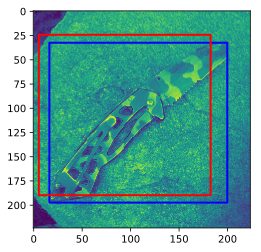

In [66]:
show_results(1898)

tensor([ 72.8000,  24.7333, 156.8000, 201.1333])
tensor(1, device='cuda:0')
[69.05805969238281, 45.632564544677734, 168.424072265625, 189.72457885742188]
Label is: human_body , Predicted: human_body


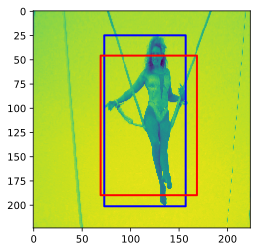

In [73]:
show_results(950)

tensor([ 31.9529,  34.7672, 203.5765, 215.5565])
tensor(0, device='cuda:0')
[40.49333953857422, 39.53852081298828, 178.29713439941406, 195.70346069335938]
Label is: horse , Predicted: horse


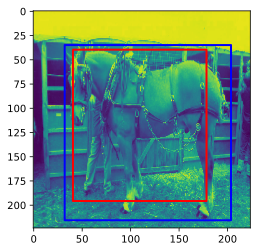

In [75]:
show_results(350)